In [ ]:
pip install stable-baselines3[extra] highway-env

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 12.7 MB/s eta 0:00:00


In [ ]:
import os
import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import DQN, A2C, PPO, SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.logger import configure
from gymnasium.wrappers import FlattenObservation
import highway_env
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt
import random

# env maker
def make_env():
    def _init():
        cfg = {
            "observation": {
            "type": "GrayscaleObservation",
            "observation_shape": (128, 64),
            "stack_size": 4,
            "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
            "scaling": 1.75,
          }
        }
        env = gym.make("intersection-v0", config=cfg)
        env = Monitor(env)
        return env
    return _init


# config generator that uses random samples
def sample_config():
    # Ranges chosen to actually matter for PPO on control tasks
    return {
        "learning_rate": float(10 ** np.random.uniform(-5, -3)), # selects a random learning rate between 1e-5 and 1e-3
        "gamma": float(np.random.uniform(0.95, 0.999)),
        "gae_lambda": float(np.random.uniform(0.8, 1.0)), # GAE lambda parameter
        "clip_range": float(np.random.uniform(0.1, 0.3)),
        "ent_coef": float(10 ** np.random.uniform(-4, -2)),
    }


# default training method that returns mean reward and trained model
def train(config, total_steps=20000, seed=None, run_id=None):
    if seed is None:
        seed = np.random.randint(0, 10_000_000)

    train_rewards = []
    train_timesteps = []

    # Build environment
    env = DummyVecEnv([make_env()])
    env = VecMonitor(env)

    # Build evaluation callback
    eval_env = DummyVecEnv([make_env()])
    eval_env = VecMonitor(eval_env)

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=None,
        n_eval_episodes=5,
        eval_freq=5000,
        deterministic=True,
        verbose=0
    )

    # Create PPO model
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        gae_lambda=config["gae_lambda"],
        clip_range=config["clip_range"],
        ent_coef=config["ent_coef"],
        n_steps=512,
        batch_size=64,
        verbose=1,
        seed=seed,
    )

    chunk = 1000
    timesteps = 0 # current timestep

    while timesteps < total_steps:
        step_now = min(chunk, total_steps - timesteps)
        model.learn(total_timesteps=step_now, reset_num_timesteps=False, callback=eval_callback, progress_bar=True) # continue training without resetting timestep count (allows the model to keep training even though we are interrupting it to log rewards  )
        # save model for first chunk (testing purposes)
        # VecMonitor exposes rewards per episode
        infos = model.ep_info_buffer  # returns list per env
        if infos:
            recent_info = list(infos)[-5:]          # convert deque → list, then slice
            recent_rewards = [d["r"] for d in recent_info]
            train_rewards.append(np.mean(recent_rewards))
            train_timesteps.append(timesteps + step_now)

        timesteps += step_now

    model.save(f"ppo_intersection_run{run_id}")

    mean_reward = np.mean(eval_callback.last_mean_reward)

    return mean_reward, train_timesteps, train_rewards


# Train longer method for top seeds

def train_long(config, total_steps=40000, seeds=(0,1,2)):
    long_runs = []  # store curves for plotting

    for s in seeds:
        mean_reward, t_steps, t_rewards = train(
            config,
            total_steps=total_steps,
            seed=s,
            run_id=None
        )

        long_runs.append({
            "config": config,
            "seed": s,
            "timesteps": t_steps,
            "rewards": t_rewards
        })

    # Compute mean final eval reward for the config over all seeds
    final_rewards = [np.mean(r["rewards"][-5:]) for r in long_runs if len(r["rewards"]) > 0]
    mean_final = np.mean(final_rewards)
    std_final = np.std(final_rewards)

    return mean_final, std_final, long_runs

def plot_long_training_curves(long_run_results, top_configs, output="topk_long_curves.png"):
    # Extract configs only
    top_cfgs = [item[1] for item in top_configs]

    plt.figure(figsize=(10, 6))

    for run in long_run_results:
        cfg = run["config"]
        if cfg in top_cfgs:
            ts = run["timesteps"]
            rs = run["rewards"]

            # Label includes seed and some hyperparams
            label = (
                f"lr={cfg['learning_rate']:.1e}, "
                f"clip={cfg['clip_range']:.2f}, "
                f"γ={cfg['gamma']:.3f}, "
                f"λ={cfg['gae_lambda']:.2f}, "
                f"seed={run['seed']}"
            )

            plt.plot(ts, rs, alpha=0.7, label=label)

    plt.title(f"Top-{len(top_cfgs)} PPO Configs (Long Training)")
    plt.xlabel("Timesteps")
    plt.ylabel("Mean Episode Reward (smoothed)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output, dpi=200)
    plt.show()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: De

In [ ]:
# hyperparameter optimization procedure

N_CONFIGS = 20 # Number of hyperparameter configurations to sample (kept small for time constraints)
SHORT_STEPS = 20000
TOP_K = 3

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,024/1,000  [ 0:01:20 < 0:00:00 , 13 it/s ]

[20/20] reward=5.88  cfg={'learning_rate': 0.00029785409805716293, 'gamma': 0.9525394666142846, 'gae_lambda': 0.910884356116796, 'clip_range': 0.22248788010626258, 'ent_coef': 0.001189739988245054}


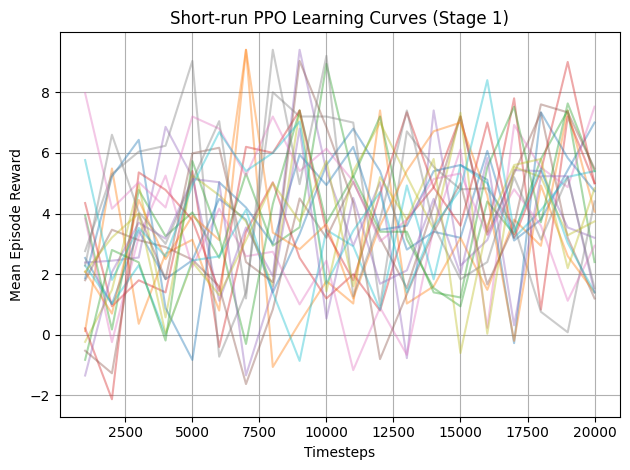

In [ ]:


results = []

for i in range(N_CONFIGS):
    cfg = sample_config()
    mean_r, t_steps, t_rewards = train(cfg, SHORT_STEPS, run_id=i)

    results.append({"mean_reward": mean_r,
                     "config": cfg,
                     "timesteps": t_steps,
                     "rewards": t_rewards})

    print(f"[{i+1}/{N_CONFIGS}] reward={mean_r:.2f}  cfg={cfg}")

for run in results:
    ts = run["timesteps"]
    rs = run["rewards"]
    plt.plot(ts, rs, alpha=0.4)

plt.title("Short-run PPO Learning Curves (Stage 1)")
plt.xlabel("Timesteps")
plt.ylabel("Mean Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.savefig("stage1_learning_curves.png", dpi=200)
plt.show()

In [ ]:
results

[{'mean_reward': np.float64(2.715830087661743),
  'config': {'learning_rate': 5.237885859707087e-05,
   'gamma': 0.9571344692243912,
   'gae_lambda': 0.9230796477772829,
   'clip_range': 0.17756462332816508,
   'ent_coef': 0.00018997812704991436},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(2.5342398),
   np.float32(1.0135424),
   np.float32(3.4373372),
   np.float32(1.8360832),
   np.float32(2.4603004),
   np.float32(4.4853563),
   np.float32(3.8),
   np.float32(1.4),
   np.float32(3.325346),
   np.float32(5.6),
   np.float32(6.8),
   np.float32(5.4),
   np.float32(2.8107169),
   np.float32(3.4),
   np.float32(3.2),
   np.float32(6.066625),
   np.float32(3.1110072),
   np.float32(3.8),
   np.float32(5.4317503),
   np.float32(7.0)]},
 {'mean_reward': np.float64(3.684094190597534),
  'config': {'learning

In [ ]:
# @title
# Had to copy cell output back into the session because runtime disconnected and all actual variables were lost

results = [{'mean_reward': np.float64(2.715830087661743),
  'config': {'learning_rate': 5.237885859707087e-05,
   'gamma': 0.9571344692243912,
   'gae_lambda': 0.9230796477772829,
   'clip_range': 0.17756462332816508,
   'ent_coef': 0.00018997812704991436},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(2.5342398),
   np.float32(1.0135424),
   np.float32(3.4373372),
   np.float32(1.8360832),
   np.float32(2.4603004),
   np.float32(4.4853563),
   np.float32(3.8),
   np.float32(1.4),
   np.float32(3.325346),
   np.float32(5.6),
   np.float32(6.8),
   np.float32(5.4),
   np.float32(2.8107169),
   np.float32(3.4),
   np.float32(3.2),
   np.float32(6.066625),
   np.float32(3.1110072),
   np.float32(3.8),
   np.float32(5.4317503),
   np.float32(7.0)]},
 {'mean_reward': np.float64(3.684094190597534),
  'config': {'learning_rate': 0.0006332720586320964,
   'gamma': 0.991754451704363,
   'gae_lambda': 0.9975680965789296,
   'clip_range': 0.21527286686977398,
   'ent_coef': 0.0008064549231301456},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(0.12541609),
   np.float32(5.484685),
   np.float32(0.3643015),
   np.float32(2.6805267),
   np.float32(3.136256),
   np.float32(0.8),
   np.float32(9.4),
   np.float32(-1.059476),
   np.float32(0.4),
   np.float32(1.7717514),
   np.float32(1.0318321),
   np.float32(7.4),
   np.float32(1.031832),
   np.float32(1.6),
   np.float32(3.2),
   np.float32(1.4840161),
   np.float32(3.8),
   np.float32(2.936256),
   np.float32(7.4),
   np.float32(4.0631914)]},
 {'mean_reward': np.float64(2.799999952316284),
  'config': {'learning_rate': 0.0004983962921387269,
   'gamma': 0.9602616551680221,
   'gae_lambda': 0.8871900217399284,
   'clip_range': 0.2447157437994323,
   'ent_coef': 0.001365355573321006},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(3.9347687),
   np.float32(0.17554808),
   np.float32(4.774496),
   np.float32(3.2507052),
   np.float32(4.03763),
   np.float32(2.5400155),
   np.float32(5.323485),
   np.float32(2.9400895),
   np.float32(3.5476708),
   np.float32(8.936241),
   np.float32(5.2),
   np.float32(7.2),
   np.float32(3.1554527),
   np.float32(1.5400155),
   np.float32(0.94001544),
   np.float32(4.4),
   np.float32(3.3240829),
   np.float32(5.8),
   np.float32(7.4),
   np.float32(2.4)]},
 {'mean_reward': np.float64(1.2000000476837158),
  'config': {'learning_rate': 0.0006528973873544513,
   'gamma': 0.9900798645619016,
   'gae_lambda': 0.9396553234996776,
   'clip_range': 0.2533918881877174,
   'ent_coef': 0.004174761684545027},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(4.345604),
   np.float32(0.9417839),
   np.float32(1.8),
   np.float32(1.4),
   np.float32(5.4),
   np.float32(-0.4),
   np.float32(3.4),
   np.float32(5.031832),
   np.float32(2.5400894),
   np.float32(1.2),
   np.float32(2.0),
   np.float32(0.8),
   np.float32(3.8),
   np.float32(4.8655353),
   np.float32(7.2),
   np.float32(3.4),
   np.float32(7.8),
   np.float32(0.83183205),
   np.float32(7.2),
   np.float32(5.0)]},
 {'mean_reward': np.float64(1.031750202178955),
  'config': {'learning_rate': 0.00013397653124880743,
   'gamma': 0.9696382947845001,
   'gae_lambda': 0.9787646403340007,
   'clip_range': 0.29380703296281396,
   'ent_coef': 0.00030130456035501094},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(2.3842638),
   np.float32(2.4447498),
   np.float32(2.5499783),
   np.float32(6.8594465),
   np.float32(5.2),
   np.float32(1.1231835),
   np.float32(3.5400894),
   np.float32(1.9400895),
   np.float32(9.4),
   np.float32(5.4),
   np.float32(2.9400153),
   np.float32(5.03175),
   np.float32(-0.7682638),
   np.float32(7.4),
   np.float32(2.284),
   np.float32(3.1266224),
   np.float32(5.4318323),
   np.float32(5.4),
   np.float32(3.5400155),
   np.float32(3.2)]},
 {'mean_reward': np.float64(3.200000047683716),
  'config': {'learning_rate': 0.00018119562122789876,
   'gamma': 0.9640815968643689,
   'gae_lambda': 0.9051274180922565,
   'clip_range': 0.1067674066997907,
   'ent_coef': 0.0030168808559724305},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(1.8004),
   np.float32(3.4667103),
   np.float32(3.1216788),
   np.float32(2.8954797),
   np.float32(2.4774134),
   np.float32(1.6),
   np.float32(-1.6232961),
   np.float32(0.837397),
   np.float32(4.4975996),
   np.float32(3.2),
   np.float32(5.0468874),
   np.float32(3.2),
   np.float32(1.5400895),
   np.float32(4.259456),
   np.float32(7.2072997),
   np.float32(3.311781),
   np.float32(5.326633),
   np.float32(7.3266325),
   np.float32(3.2),
   np.float32(1.2)]},
 {'mean_reward': np.float64(3.799999952316284),
  'config': {'learning_rate': 1.7838866063906457e-05,
   'gamma': 0.9578097586280268,
   'gae_lambda': 0.8524041649815165,
   'clip_range': 0.1977754675704114,
   'ent_coef': 0.007489156649390281},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(3.833112),
   np.float32(-0.23985691),
   np.float32(3.2357833),
   np.float32(5.251315),
   np.float32(2.2314568),
   np.float32(4.1601653),
   np.float32(2.58987),
   np.float32(2.7413268),
   np.float32(1.0039018),
   np.float32(2.4473476),
   np.float32(-1.1628561),
   np.float32(0.902074),
   np.float32(-0.6599847),
   np.float32(3.5363266),
   np.float32(6.11175),
   np.float32(0.2317502),
   np.float32(6.923129),
   np.float32(5.5152407),
   np.float32(4.87082),
   np.float32(7.5231185)]},
 {'mean_reward': np.float64(7.199999809265137),
  'config': {'learning_rate': 0.00032012535844510063,
   'gamma': 0.9663284594459708,
   'gae_lambda': 0.843686100013944,
   'clip_range': 0.1700329417462239,
   'ent_coef': 0.0007152444556147651},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(2.7631555),
   np.float32(5.3038435),
   np.float32(6.0396423),
   np.float32(6.2354126),
   np.float32(9.033201),
   np.float32(-0.7198952),
   np.float32(1.4),
   np.float32(8.0),
   np.float32(7.2),
   np.float32(7.2),
   np.float32(7.0),
   np.float32(0.9722742),
   np.float32(6.7100363),
   np.float32(5.540015),
   np.float32(4.8),
   np.float32(4.831736),
   np.float32(3.6),
   np.float32(0.7605154),
   np.float32(0.08401604),
   np.float32(4.4)]},
 {'mean_reward': np.float64(3.7400155067443848),
  'config': {'learning_rate': 0.00013846585245045018,
   'gamma': 0.9906277183364592,
   'gae_lambda': 0.8051792110212346,
   'clip_range': 0.24420894279895936,
   'ent_coef': 0.00016636227020399715},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(-0.23123655),
   np.float32(1.479343),
   np.float32(4.967978),
   np.float32(0.5754884),
   np.float32(5.2628746),
   np.float32(4.6),
   np.float32(3.7400155),
   np.float32(1.6),
   np.float32(7.4),
   np.float32(1.4318321),
   np.float32(5.4),
   np.float32(7.0),
   np.float32(5.23175),
   np.float32(3.484016),
   np.float32(7.323129),
   np.float32(0.037727736),
   np.float32(5.540015),
   np.float32(5.2),
   np.float32(3.2840161),
   np.float32(3.7400002)]},
 {'mean_reward': np.float64(7.400000095367432),
  'config': {'learning_rate': 0.0006239663029595048,
   'gamma': 0.9539191228123143,
   'gae_lambda': 0.8060791633470962,
   'clip_range': 0.11206251236780879,
   'ent_coef': 0.0003203130645427168},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(2.28508),
   np.float32(1.0206969),
   np.float32(2.2953415),
   np.float32(0.0084874155),
   np.float32(2.4520454),
   np.float32(2.5882118),
   np.float32(4.1234846),
   np.float32(1.4),
   np.float32(-0.8599105),
   np.float32(3.459413),
   np.float32(2.9234848),
   np.float32(0.8317502),
   np.float32(4.9266224),
   np.float32(1.8317502),
   np.float32(5.6),
   np.float32(5.0),
   np.float32(3.2),
   np.float32(4.1117415),
   np.float32(5.2071304),
   np.float32(5.4)]},
 {'mean_reward': np.float64(7.0),
  'config': {'learning_rate': 0.000333449393489936,
   'gamma': 0.9561663737202232,
   'gae_lambda': 0.8934949563842677,
   'clip_range': 0.27534625314225036,
   'ent_coef': 0.0004509823611704631},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(1.8653488),
   np.float32(5.217923),
   np.float32(6.431389),
   np.float32(0.88401604),
   np.float32(-0.82807845),
   np.float32(5.031832),
   np.float32(4.2),
   np.float32(3.0),
   np.float32(5.9400024),
   np.float32(4.9400153),
   np.float32(6.2),
   np.float32(3.4634862),
   np.float32(3.6),
   np.float32(5.4),
   np.float32(5.6),
   np.float32(5.115766),
   np.float32(-0.27331495),
   np.float32(7.3400025),
   np.float32(5.831736),
   np.float32(4.7400026)]},
 {'mean_reward': np.float64(5.599999904632568),
  'config': {'learning_rate': 9.842693759201363e-05,
   'gamma': 0.9773636698219164,
   'gae_lambda': 0.9103573527357337,
   'clip_range': 0.27383415984098836,
   'ent_coef': 0.006322606924274506},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(2.0889816),
   np.float32(0.70053816),
   np.float32(4.4469743),
   np.float32(2.4951012),
   np.float32(3.9266331),
   np.float32(3.1253488),
   np.float32(9.4),
   np.float32(3.3717525),
   np.float32(2.8231914),
   np.float32(3.6504264),
   np.float32(1.2),
   np.float32(3.6),
   np.float32(5.409362),
   np.float32(6.713173),
   np.float32(7.0),
   np.float32(4.6),
   np.float32(-0.2),
   np.float32(4.9237022),
   np.float32(2.6),
   np.float32(1.4)]},
 {'mean_reward': np.float64(1.7400153875350952),
  'config': {'learning_rate': 2.7131264457332005e-05,
   'gamma': 0.952064787445871,
   'gae_lambda': 0.92602979317187,
   'clip_range': 0.27946072742856154,
   'ent_coef': 0.00014358884672779578},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(-0.8231166),
   np.float32(2.79945),
   np.float32(2.3901966),
   np.float32(-0.18786831),
   np.float32(5.7302713),
   np.float32(3.2332275),
   np.float32(-0.30050588),
   np.float32(4.3105106),
   np.float32(7.4),
   np.float32(3.684016),
   np.float32(5.231734),
   np.float32(3.4),
   np.float32(3.4),
   np.float32(1.4),
   np.float32(1.231832),
   np.float32(5.524083),
   np.float32(7.523484),
   np.float32(3.7125885),
   np.float32(7.631736),
   np.float32(5.4)]},
 {'mean_reward': np.float64(7.400000095367432),
  'config': {'learning_rate': 0.00026444187211961223,
   'gamma': 0.9705047273984693,
   'gae_lambda': 0.9844069900771479,
   'clip_range': 0.16088732334516534,
   'ent_coef': 0.0001517482044036583},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(0.21324244),
   np.float32(-2.124455),
   np.float32(5.3563857),
   np.float32(4.7794056),
   np.float32(3.7863972),
   np.float32(1.447212),
   np.float32(6.2),
   np.float32(6.0),
   np.float32(7.4),
   np.float32(3.4),
   np.float32(1.8),
   np.float32(4.651516),
   np.float32(7.3400154),
   np.float32(4.8634934),
   np.float32(3.6),
   np.float32(7.0),
   np.float32(3.2),
   np.float32(5.4),
   np.float32(9.0),
   np.float32(5.0)]},
 {'mean_reward': np.float64(6.199999809265137),
  'config': {'learning_rate': 5.649234628523674e-05,
   'gamma': 0.9734714781148013,
   'gae_lambda': 0.8027798255571431,
   'clip_range': 0.25482933463619595,
   'ent_coef': 0.008070339176504827},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(-1.3415972),
   np.float32(2.0675888),
   np.float32(3.6962998),
   np.float32(3.1718805),
   np.float32(5.1400156),
   np.float32(5.033193),
   np.float32(-1.3364178),
   np.float32(1.4921018),
   np.float32(6.8),
   np.float32(0.53625613),
   np.float32(4.512591),
   np.float32(1.6840026),
   np.float32(2.1254458),
   np.float32(4.484094),
   np.float32(2.0),
   np.float32(5.8317337),
   np.float32(0.31583214),
   np.float32(5.23175),
   np.float32(5.231736),
   np.float32(1.4)]},
 {'mean_reward': np.float64(5.084015846252441),
  'config': {'learning_rate': 0.00017690293354520945,
   'gamma': 0.9583699193533621,
   'gae_lambda': 0.8847800384365355,
   'clip_range': 0.10650639255957584,
   'ent_coef': 0.0007938766557705342},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(-0.5242022),
   np.float32(-1.2678082),
   np.float32(3.9827094),
   np.float32(1.834988),
   np.float32(5.985013),
   np.float32(6.169767),
   np.float32(2.4),
   np.float32(1.7400154),
   np.float32(9.033609),
   np.float32(6.8462954),
   np.float32(4.3679914),
   np.float32(-0.8),
   np.float32(1.3400896),
   np.float32(3.4),
   np.float32(5.0),
   np.float32(1.6601883),
   np.float32(3.6),
   np.float32(7.6),
   np.float32(7.3362412),
   np.float32(5.484016)]},
 {'mean_reward': np.float64(4.199999809265137),
  'config': {'learning_rate': 0.0002159371584092056,
   'gamma': 0.9715195374281272,
   'gae_lambda': 0.9068620296812876,
   'clip_range': 0.2765961382470304,
   'ent_coef': 0.00016571075148319082},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(7.9705415),
   np.float32(4.159174),
   np.float32(5.0345936),
   np.float32(4.2),
   np.float32(7.2),
   np.float32(6.8),
   np.float32(5.250402),
   np.float32(7.2),
   np.float32(5.4),
   np.float32(6.1400003),
   np.float32(5.0634933),
   np.float32(3.084094),
   np.float32(3.8),
   np.float32(5.1400156),
   np.float32(5.323203),
   np.float32(3.2840161),
   np.float32(4.8),
   np.float32(3.6),
   np.float32(1.1235864),
   np.float32(2.9362416)]},
 {'mean_reward': np.float64(2.4634695053100586),
  'config': {'learning_rate': 0.0004986094166414074,
   'gamma': 0.989070164900683,
   'gae_lambda': 0.8293729202396423,
   'clip_range': 0.291801346283857,
   'ent_coef': 0.006626819072274191},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(2.2850006),
   np.float32(6.597528),
   np.float32(4.051526),
   np.float32(3.0),
   np.float32(5.084016),
   np.float32(7.0466166),
   np.float32(1.2),
   np.float32(9.4),
   np.float32(4.96811),
   np.float32(9.2),
   np.float32(1.2667123),
   np.float32(3.8),
   np.float32(7.4),
   np.float32(3.6),
   np.float32(1.8317502),
   np.float32(2.4),
   np.float32(5.2),
   np.float32(3.1400154),
   np.float32(5.2),
   np.float32(1.5400026)]},
 {'mean_reward': np.float64(7.431735992431641),
  'config': {'learning_rate': 0.00016047865577288476,
   'gamma': 0.9972333738718513,
   'gae_lambda': 0.8591662103998138,
   'clip_range': 0.29561000733453685,
   'ent_coef': 0.0007472898347021409},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(2.0730805),
   np.float32(3.2080855),
   np.float32(4.009423),
   np.float32(0.03485899),
   np.float32(2.4),
   np.float32(1.3126055),
   np.float32(3.1253605),
   np.float32(5.0),
   np.float32(3.7400155),
   np.float32(5.7400155),
   np.float32(1.6),
   np.float32(5.2),
   np.float32(3.8),
   np.float32(5.8),
   np.float32(-0.6),
   np.float32(3.6),
   np.float32(5.6),
   np.float32(5.8),
   np.float32(2.2),
   np.float32(4.83175)]},
 {'mean_reward': np.float64(5.884000301361084),
  'config': {'learning_rate': 0.00029785409805716293,
   'gamma': 0.9525394666142846,
   'gae_lambda': 0.910884356116796,
   'clip_range': 0.22248788010626258,
   'ent_coef': 0.001189739988245054},
  'timesteps': [1000,
   2000,
   3000,
   4000,
   5000,
   6000,
   7000,
   8000,
   9000,
   10000,
   11000,
   12000,
   13000,
   14000,
   15000,
   16000,
   17000,
   18000,
   19000,
   20000],
  'rewards': [np.float32(5.7631884),
   np.float32(1.8122566),
   np.float32(3.526633),
   np.float32(2.587776),
   np.float32(4.926623),
   np.float32(6.6840944),
   np.float32(5.4),
   np.float32(6.0),
   np.float32(7.0317507),
   np.float32(1.684016),
   np.float32(3.43175),
   np.float32(4.7073474),
   np.float32(1.4),
   np.float32(3.5717514),
   np.float32(4.8),
   np.float32(8.4),
   np.float32(3.4),
   np.float32(5.484016),
   np.float32(3.031736),
   np.float32(1.4)]}]



In [ ]:
# Select top configs based on highest average reward
results.sort(key=lambda x: x['mean_reward'], reverse=True)
top_configs = results[:TOP_K]

print("\nTop short-run configs:")
for config in top_configs:
    print(config['mean_reward'], config['config'])


Top short-run configs:
7.431735992431641 {'learning_rate': 0.00016047865577288476, 'gamma': 0.9972333738718513, 'gae_lambda': 0.8591662103998138, 'clip_range': 0.29561000733453685, 'ent_coef': 0.0007472898347021409}
7.400000095367432 {'learning_rate': 0.0006239663029595048, 'gamma': 0.9539191228123143, 'gae_lambda': 0.8060791633470962, 'clip_range': 0.11206251236780879, 'ent_coef': 0.0003203130645427168}
7.400000095367432 {'learning_rate': 0.00026444187211961223, 'gamma': 0.9705047273984693, 'gae_lambda': 0.9844069900771479, 'clip_range': 0.16088732334516534, 'ent_coef': 0.0001517482044036583}


mean reward = 7.431735992431641max reward = 5.8
mean reward = 7.400000095367432max reward = 5.6
mean reward = 7.400000095367432max reward = 9.0


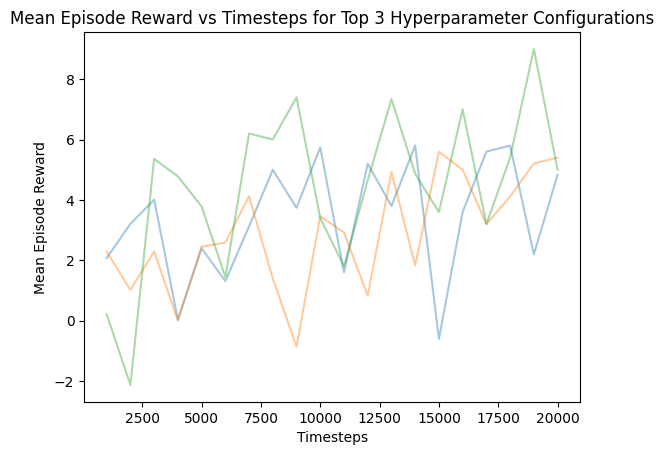

In [ ]:
# Plot top K timesteps

plt.xlabel("Timesteps")
plt.ylabel("Mean Episode Reward")
plt.title("Mean Episode Reward vs Timesteps for Top 3 Hyperparameter Configurations")
for run in top_configs:
    rs = run['rewards']
    ts = run['timesteps']
    print("mean reward = " + str(run['mean_reward']) + "max reward = " + str(max(rs)))
    plt.plot(ts, rs, alpha=0.4)

# Task
Save the `results` list as a pickle file, collect all PPO model files, create a zip archive containing both the results file and the model files, and then provide a download link for the archive.

## Save Results

### Subtask:
Save the `results` list to a pickle file.


**Reasoning**:
The user wants to save the `results` list to a pickle file. I will use the `pickle` module to serialize the list and write it to a file named 'results.pkl'.



In [ ]:
import pickle

with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved to 'results.pkl'")

## Collect Model Files


In [ ]:
import os

# Get a list of all files in the current directory
all_files = os.listdir('.')

# Filter the list to include only files whose names start with 'ppo_intersection_run'
model_files = [f for f in all_files if f.startswith('ppo_intersection_run')]

print(f"Identified {len(model_files)} PPO model files:")
for model_file in model_files:
    print(model_file)

## Create Zip Archive


In [ ]:
import zipfile

archive_name = 'ppo_results_and_models.zip'

with zipfile.ZipFile(archive_name, 'w') as zipf:
    zipf.write('results.pkl')
    for model_file in model_files:
        zipf.write(model_file)

print(f"Successfully created archive: {archive_name}")

In [ ]:
from google.colab import files

files.download('ppo_results_and_models.zip')